# 캐글 신용카드 사기 검출 데이터 실습

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("./creditcard.csv")
print('dataset shape:', card_df.shape)
card_df.head(3)

dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# 언더 샘플링, 오버 샘플링

# 전처리 
- Time 피처 제거


## 전처리 함수 get_preprocessed_df()

In [5]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)

    
    return df_copy

In [6]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함
def get_train_test_dataset(df=None):
    #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    #DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    #학습/테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [9]:
# 분포 확인
print(f'학습데이터의 사기거래 비율은:\n{y_train.value_counts()/y_train.shape[0]*100}')
print(f'테스트데이터의 사기거래 비율은:\n{y_test.value_counts()/y_test.shape[0]*100}')

학습데이터의 사기거래 비율은:
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트데이터의 사기거래 비율은:
0    99.826785
1     0.173215
Name: Class, dtype: float64


## 출력 함수

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_probs=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차 행렬:\n', confusion)
    print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall},\
    F1: {f1}, ROC-AUC:{roc_auc}')

# 로지스틱 회귀 모델 생성 

In [26]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

print('### 로지스틱 회귀 예측 성능 ###')
get_clf_eval(y_test, lr_pred, lr_pred_proba)

### 로지스틱 회귀 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   58    90]]
정확도: 0.9991573329588147, 정밀도: 0.8653846153846154, 재현율: 0.6081081081081081,    F1: 0.7142857142857144, ROC-AUC:0.8039719859375173


## 학습/예측/평가 함수

In [16]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)


# LightGBM 모델

In [25]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### LightGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   37   111]]
정확도: 0.9995084442259752, 정밀도: 0.9568965517241379, 재현율: 0.75,    F1: 0.8409090909090909, ROC-AUC:0.8749706899583798


# 데이터 분포도 변환 후 모델 학습/예측/평가

## 1. Amount 피처

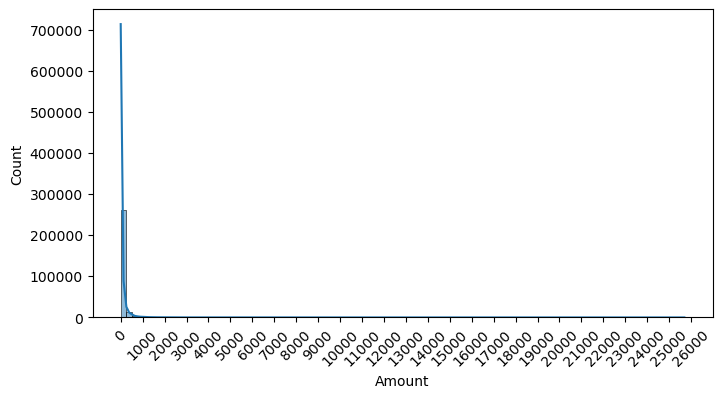

In [20]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=45)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

### 1.1 Amount - StandardScaler 스케일링 처리

In [21]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    # Amount Scaling
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_scaled로 피처명 변경후 DataFrame 맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [22]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [24]:
print('### StandardScaler+로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### StandardScaler+LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### StandardScaler+로지스틱 회귀 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   58    90]]
정확도: 0.9991573329588147, 정밀도: 0.8653846153846154, 재현율: 0.6081081081081081,    F1: 0.7142857142857144, ROC-AUC:0.8039719859375173
### StandardScaler+LightGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   37   111]]
정확도: 0.9995084442259752, 정밀도: 0.9568965517241379, 재현율: 0.75,    F1: 0.8409090909090909, ROC-AUC:0.8749706899583798


### 1.2 Amount - Log 처리

In [27]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy


In [28]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [29]:
print('### Log처리+로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### Log처리+LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### Log처리+로지스틱 회귀 예측 성능 ###
오차 행렬:
 [[85283    12]
 [   59    89]]
정확도: 0.99916903666772, 정밀도: 0.8811881188118812, 재현율: 0.6013513513513513,    F1: 0.714859437751004, ROC-AUC:0.8006053315757872
### Log처리+LightGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   35   113]]
정확도: 0.9995318516437859, 정밀도: 0.9576271186440678, 재현율: 0.7635135135135135,    F1: 0.849624060150376, ROC-AUC:0.8817274467151365


# 이상치 데이터 제거 후 모델 학습/예측/평가

## 1. 피처의 상관관계 - 중요도 파악

<AxesSubplot:>

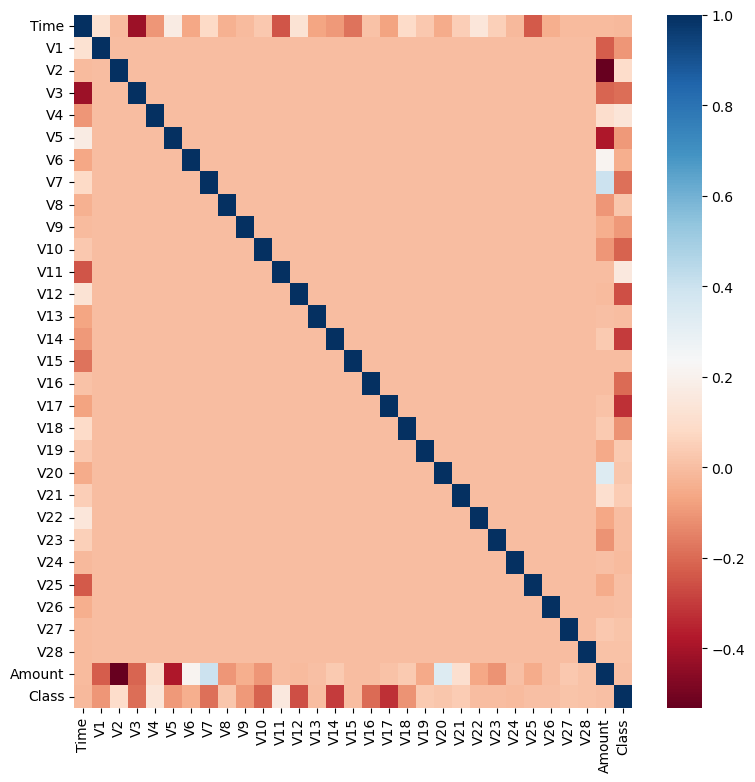

In [31]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')


결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17입니다. 이 중 V14에 대해서만 이상치를 찾아서 제거. 

## 2. 이상치 검출 함수

### 2.1 V14 컬럼 이상치 제거

In [33]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud 에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index


In [34]:
# V14 컬럼에서 이상치 찾기

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index) 

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [36]:
# 이상치가 발견된 [8296, 8615, 9035, 9252] 인덱스 - 이상치 추출, 삭제 하는 로직을 get_processed_df() 함수에 추가

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    # # V14와 V17 컬럼의 이상치 제거
    # for column in ['V14', 'V17']:
    #     outlier_index = get_outlier(df=df_copy, column=column, weight=1.5)
    #     df_copy.drop(outlier_index, axis=0, inplace=True)
    # return df_copy

    return df_copy

In [42]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### V14 이상치처리+로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### V14 이상치처리+LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### V14 이상치처리+로지스틱 회귀 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9992743530623471, 정밀도: 0.875, 재현율: 0.6712328767123288,    F1: 0.7596899224806201, ROC-AUC:0.8355343702396276
### V14 이상치처리+LightGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   25   121]]
정확도: 0.9996488805140389, 정밀도: 0.9603174603174603, 재현율: 0.8287671232876712,    F1: 0.8897058823529411, ROC-AUC:0.9143542516022153


### 2.2 V17 컬럼 이상치 제거

In [43]:
# V14 컬럼에서 이상치 찾기

outlier_index_V17 = get_outlier(df=card_df, column='V17', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index_V17) 

이상치 데이터 인덱스: Int64Index([], dtype='int64')


In [44]:
card_df.drop(outlier_index_V17, axis=0, inplace=True)

In [45]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### V17 이상치처리+로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### V17 이상치처리+LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### V17 이상치처리+로지스틱 회귀 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9992743530623471, 정밀도: 0.875, 재현율: 0.6712328767123288,    F1: 0.7596899224806201, ROC-AUC:0.8355343702396276
### V17 이상치처리+LightGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   25   121]]
정확도: 0.9996488805140389, 정밀도: 0.9603174603174603, 재현율: 0.8287671232876712,    F1: 0.8897058823529411, ROC-AUC:0.9143542516022153


# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가